### Título: Algortimo para cálculo de áreas quemadas en cuencas
### Grupo 10
#### Descripción:
Algoritmo para cálculo de focos de calor en cuencas desagregadas a nivel 2.
##### Procedimiento general
+ Se selecciona colección FireCCI_5_1
+ Se selecciona las regiones de cuencas a nivel 2 definidas en el producto
+ Se define fecha de inicio y final de análisis.
+ Se filtra la colección FireCCI_5_1 con las fecha definidas en el punto anterior
+ Se selecciona una subcolección de un mes de duración
+ Se reduce la subcolección a una escena tomando los valores máximos de los pixels
+ Se suma las áreas quemadas por cuencas en la escena reducida
+ Se registra los valores computados
+ Se selecciona la siguiente subcolección de un mes de duración. Si se termina la cantidad de subcolecciones se procede al siguiente punto.
+ Se da formato a los datos para entregarlos al procesador de variables.

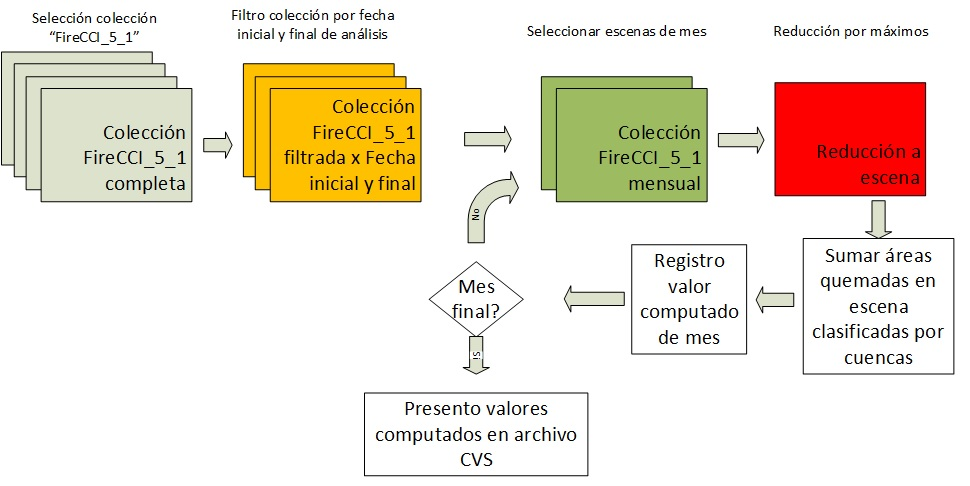

In [1]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AY0e-g4-0iW_7bil6lfwSNVIOSPTGbjSEwq4JjDFzVMb5engFr1dDfgaZoM

Successfully saved authorization token.


### Elección de tipo de cuenca mediante producto WWF HydroSHEDS Basins level 2

In [2]:
basin_id = [6020029280, 6020017370, 6020021870, 6020008320,  6020014330, 6020000010, 6020006540];
basins = ( ee.FeatureCollection("WWF/HydroSHEDS/v1/Basins/hybas_2")
         .filter(ee.Filter.inList('HYBAS_ID',basin_id))
)

In [3]:
# Función para filtrar colección FireCCI entre fechas requeridas
def compute_burned_area(start_date,end_date,basins):
    
    burned_area_collection = ( ee.ImageCollection("ESA/CCI/FireCCI/5_1") 
        .filterDate(start_date,end_date)
        .select('BurnDate')
    )
    def filter_burned_area(img):
        return img.gt(0)
    burned_area_collection = burned_area_collection.map(filter_burned_area)
    burned_area_img = burned_area_collection.max()
    result = burned_area_img.reduceRegions(**{
        'collection' : basins,
        'reducer' : ee.Reducer.sum(),
        'scale' : 250
    })
    data = result.getInfo()
   
    return data 

In [4]:
# Función tomar datos calculados y juntarlos en 1 diccionario

def format_columns(result_data):
    result_values = {}
    for feature in result_data['features']:
        prop = feature['properties']
        result_values[prop['HYBAS_ID']] = prop['sum']
    return result_values

In [5]:
# Importo módulos a utilizar para separar colecciones mensuales y medir tiempos de procesamiento

from dateutil import rrule
import datetime 
import time

# Defino fechas de interés

start_date = datetime.datetime(2001,2,1)
end_date  = datetime.datetime(2001,4,30)
start = '2001-01'
array = []
index = []

# Defino bucle para recorrer mensualmente el período de interés
for dt in rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date):
    print(dt)
    start_time = time.time()
    end = dt.strftime('%Y-%m')
    data = compute_burned_area(start,end,basins)
    values = format_columns(data)
    total_time = time.time() - start_time
    print("time=%s"%(total_time))
    index.append(start)
    array.append(values)
    start = end

2001-02-01 00:00:00
time=5.62796425819397
2001-03-01 00:00:00
time=6.2374749183654785
2001-04-01 00:00:00
time=5.922205924987793


In [6]:
# Ordeno los datos de focos de calor utilizando módulo pandas

import pandas as pd
df = pd.DataFrame(array,index=index)
df.to_csv('partial_burned_area.csv')
df

,6020000010,6020006540,6020008320,6020014330,6020017370,6020021870,6020029280
2001-01,207404.258824,11048.729412,990,3774.000000,591455.419608,2,226
2001-02,326576.352941,17229.552941,2919,6514.835294,85451.901961,478,193
2001-03,233289.031373,9871.117647,1007,9551.819608,60734.000000,3959,27


In [7]:
# Ordeno datos para entregar a compilador de datos "Superset"

name_map = { 
        6020000010 : 'Orinoco', 
        6020006540 : 'Amazonas', 
        6020029280 : 'Pacifico', 
        6020014330 : 'Parana', 
        6020017370 : 'Argentina', 
        6020021870 : 'Chile', 
        6020008320 : 'Brasil' 
}
columns = list(df.columns)
array = []
area = 250 * 250 / 1000000 #km2
for c in columns: 
    subset = df[ [ c ] ] 
    subset.rename(columns={c : 'burned_area'},inplace=True) 
    subset['basin_id'] = name_map[c]
    subset['burned_area'] = subset['burned_area'] * area
    array.append(subset)
    
total = pd.concat(array)
total.to_csv('burned_area.csv')
total

C:\Users\DiazGustavoV\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
C:\Users\DiazGustavoV\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\DiazGustavoV\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

,burned_area,basin_id
2001-01,12962.766176,Orinoco
2001-02,20411.022059,Orinoco
2001-03,14580.564461,Orinoco
2001-01,690.545588,Amazonas
2001-02,1076.847059,Amazonas
2001-03,616.944853,Amazonas
2001-01,61.875000,Brasil
2001-02,182.437500,Brasil
2001-03,62.937500,Brasil
2001-01,235.875000,Parana
